In [ ]:
# Today, AI is everywhere, we are able to do many things with it.
# I will be exploring one of the key areas within AI, classification, which is a field currently under research, and we have not fully yet found out the limitations
# We've trained AI which can classify animals, plants, cars, and medicine, among other things.
# However, the main problem in hand revolves around the AI's capability to effectively classify manipulated images and the extent of training required to enable the AI to reliably detect these altered images.
# This is where the AI is most vulnerable as it is not able to adapt quickly to evolving image manipulation techniques and this is what I will be aiming to research and come to a solution where I aim to see how easily I can manipulate the AI into classifying the hacked images.


1/1 [==============================] - 0s 56ms/step


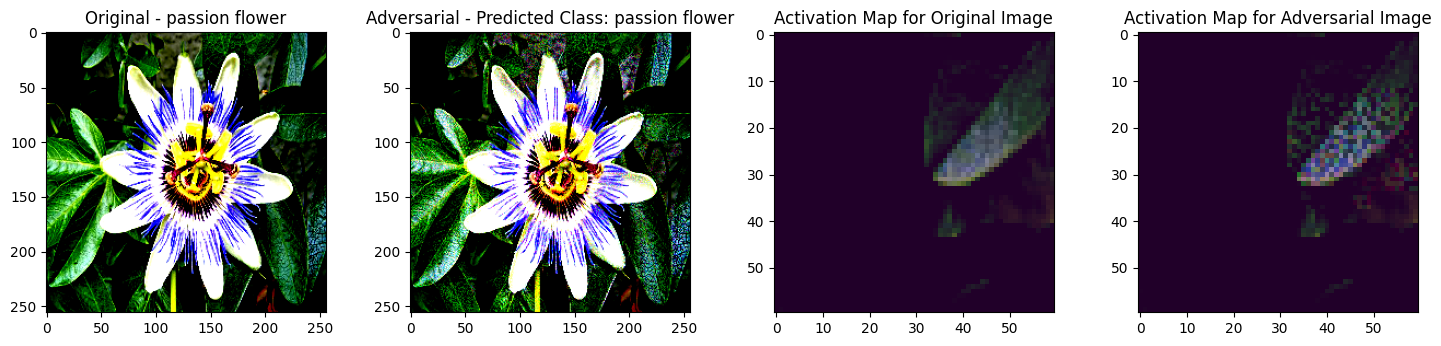

1/1 [==============================] - 0s 56ms/step


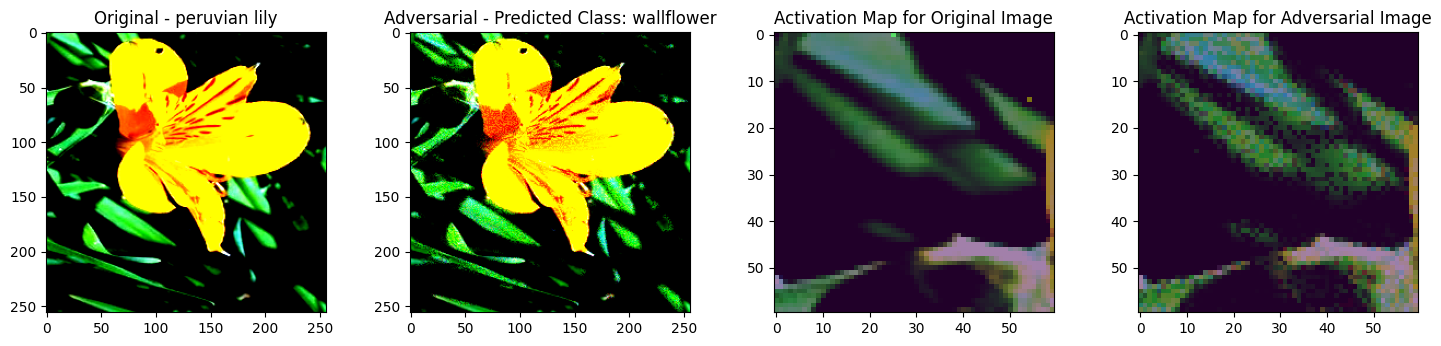

1/1 [==============================] - 0s 58ms/step


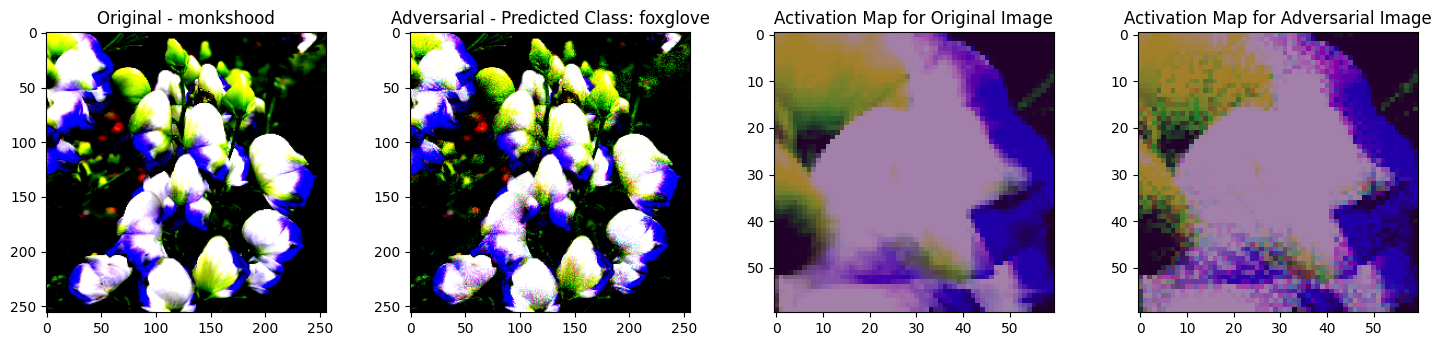

1/1 [==============================] - 0s 55ms/step


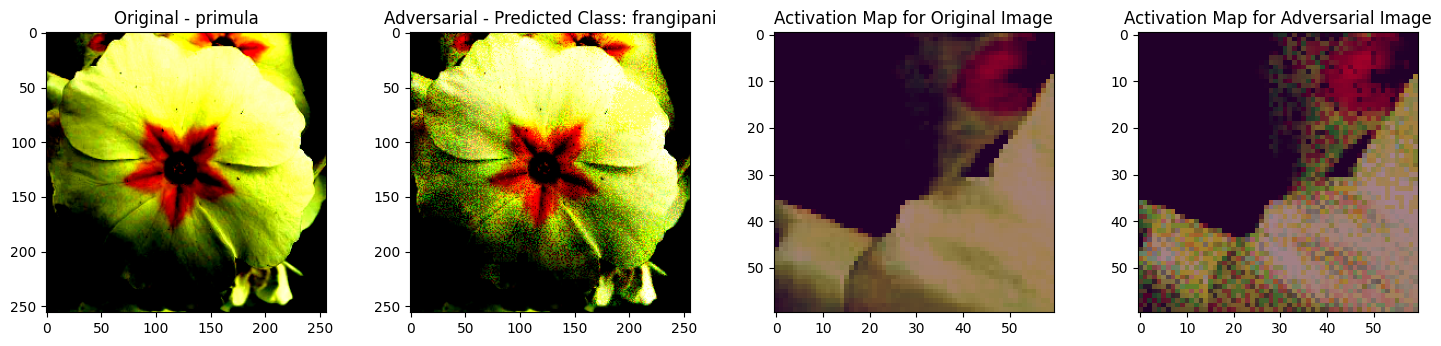

1/1 [==============================] - 0s 55ms/step


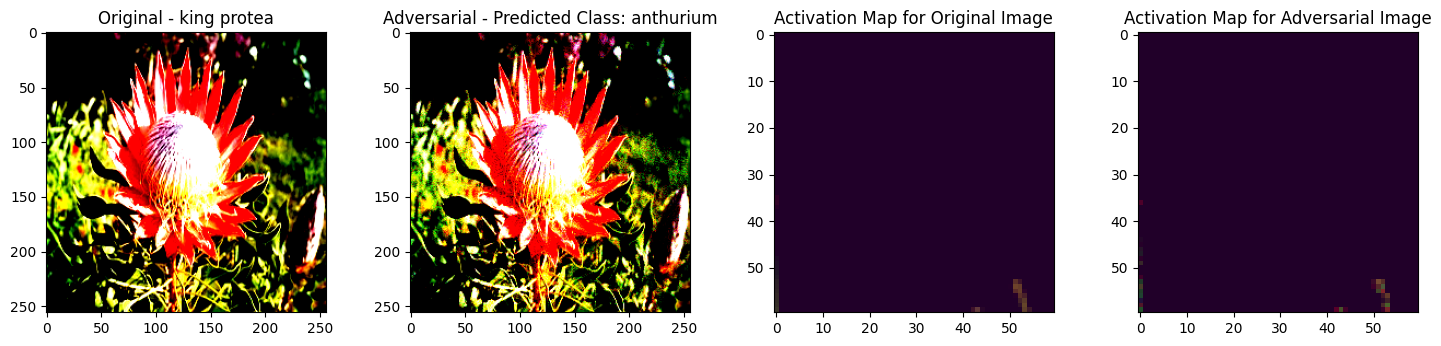

1/1 [==============================] - 0s 56ms/step


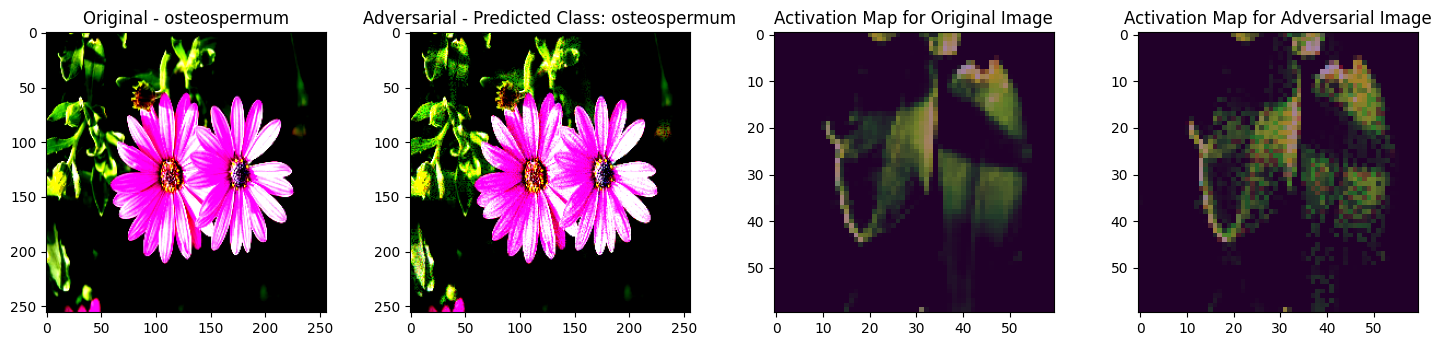

1/1 [==============================] - 0s 55ms/step


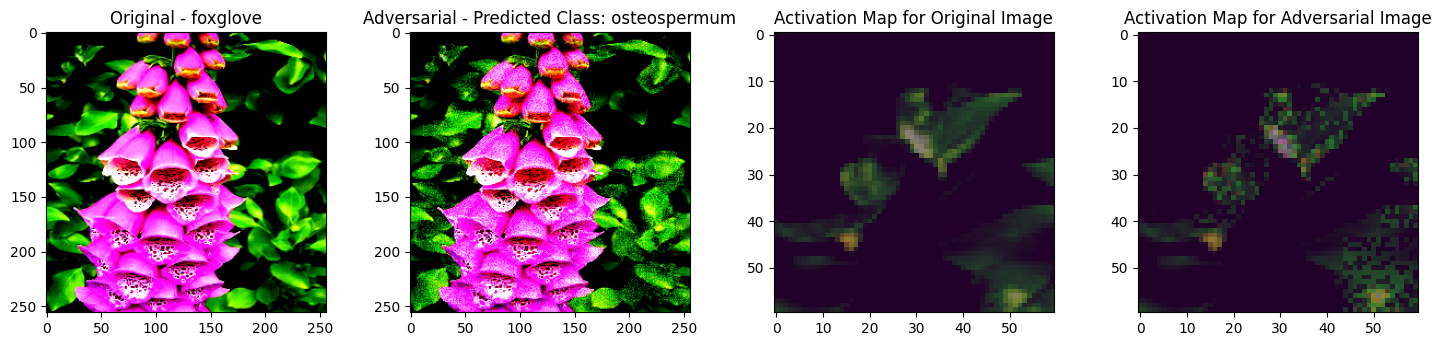

1/1 [==============================] - 0s 56ms/step


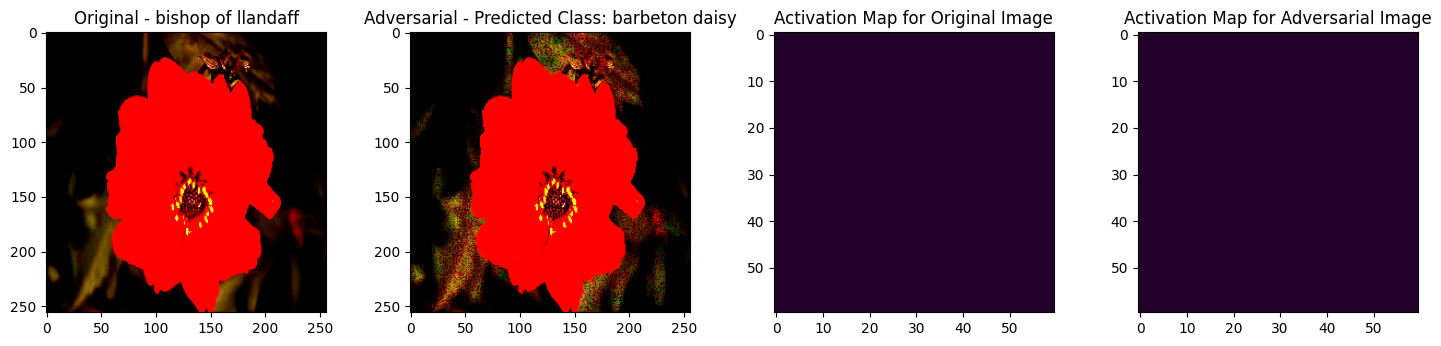

1/1 [==============================] - 0s 59ms/step


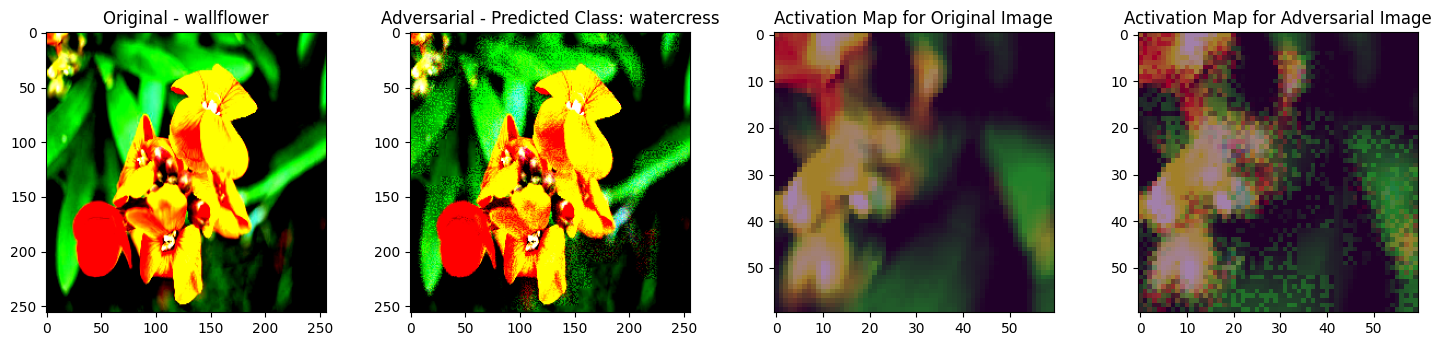

1/1 [==============================] - 0s 58ms/step


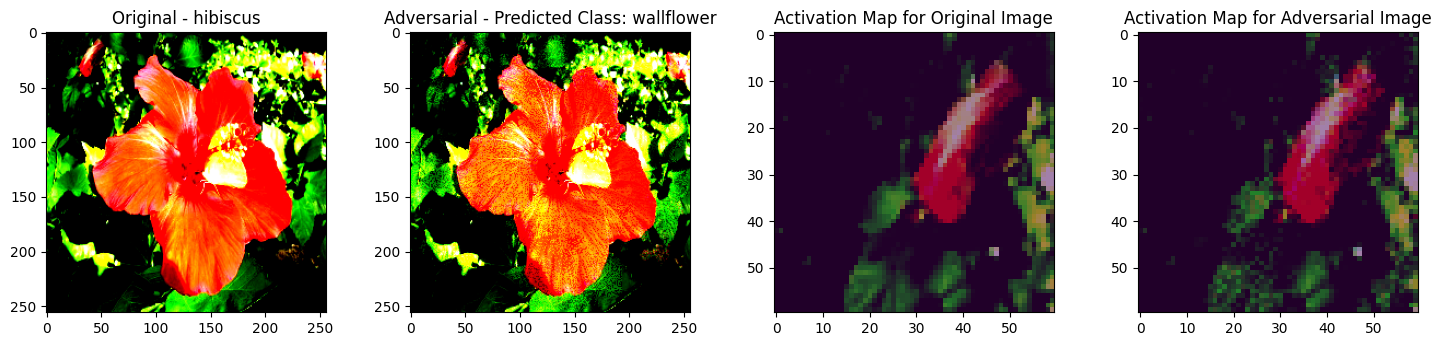

1/1 [==============================] - 0s 60ms/step


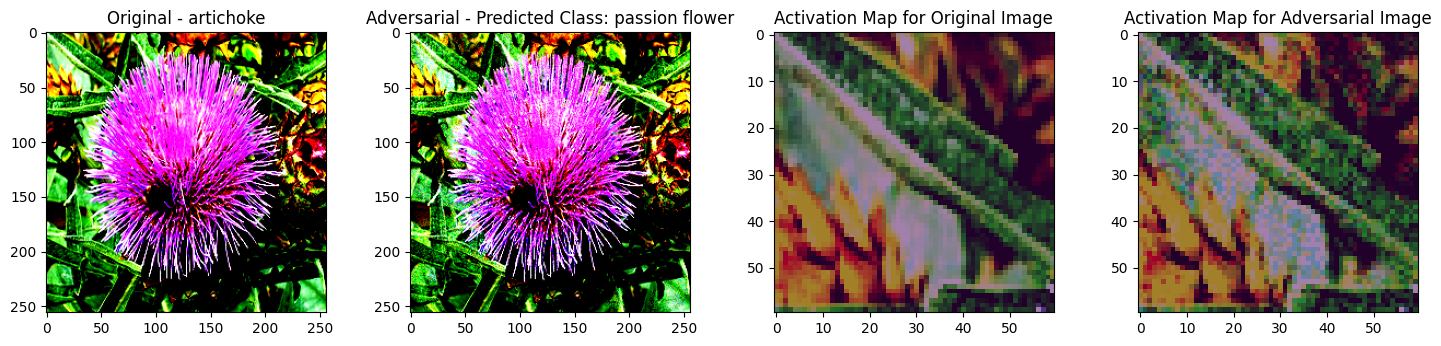

1/1 [==============================] - 0s 60ms/step


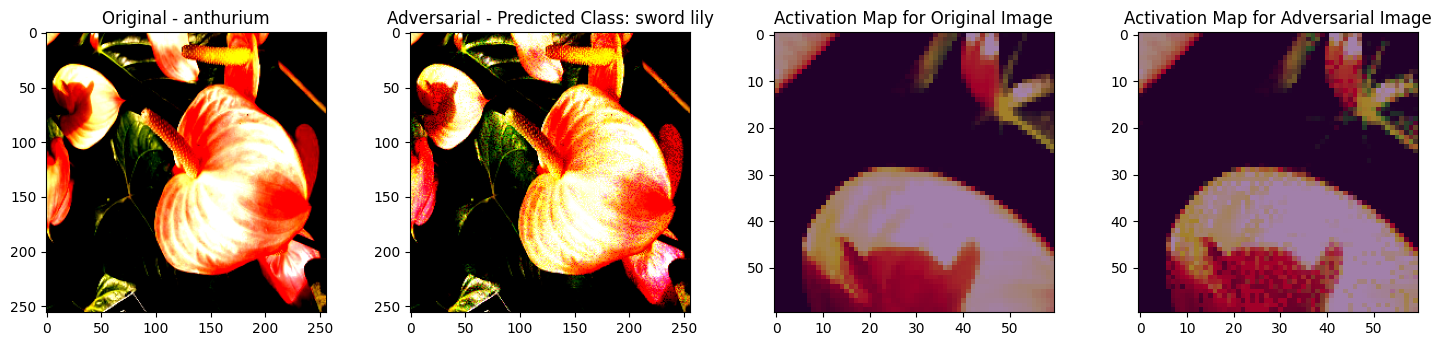

1/1 [==============================] - 0s 57ms/step


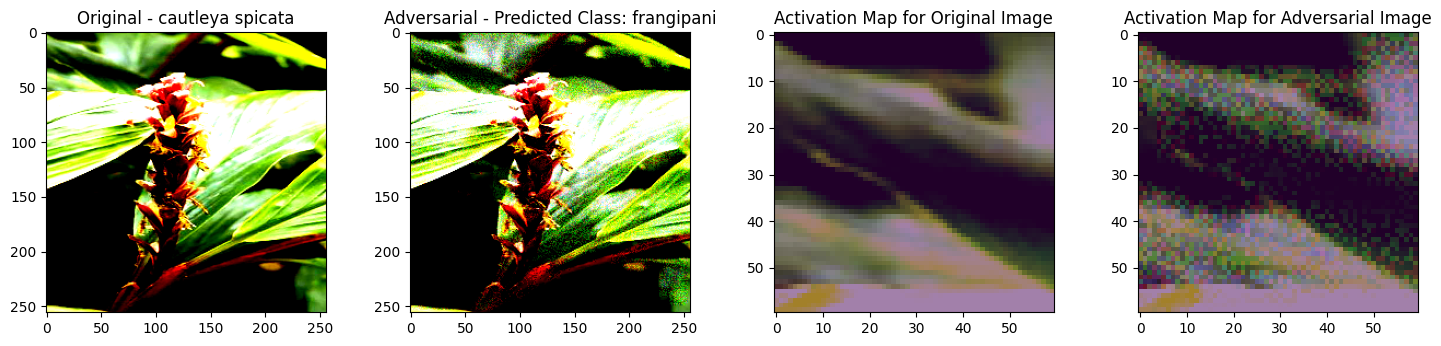

1/1 [==============================] - 0s 56ms/step


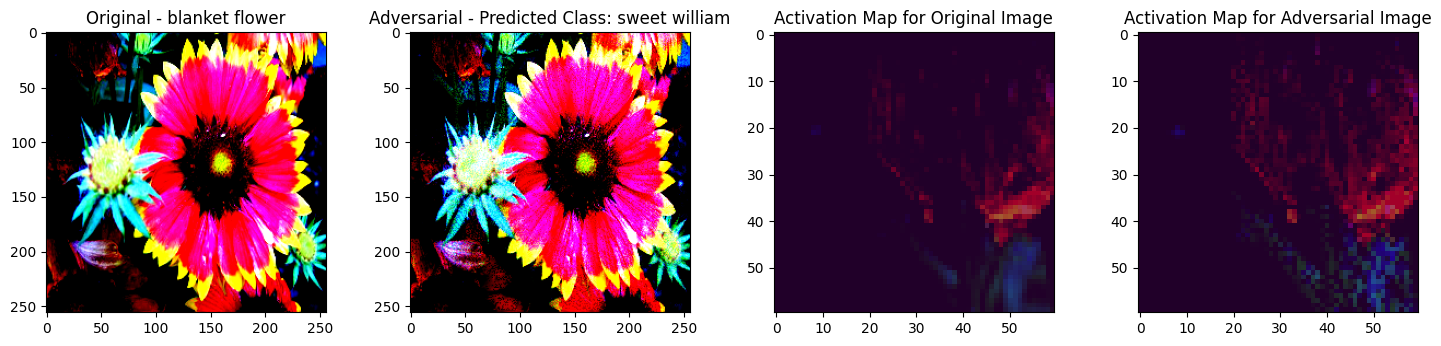

1/1 [==============================] - 0s 56ms/step


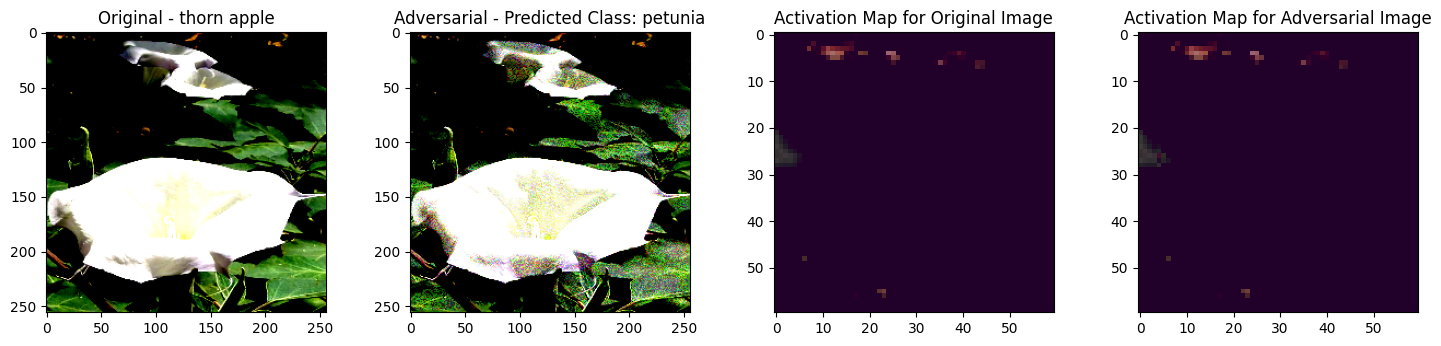

1/1 [==============================] - 0s 56ms/step


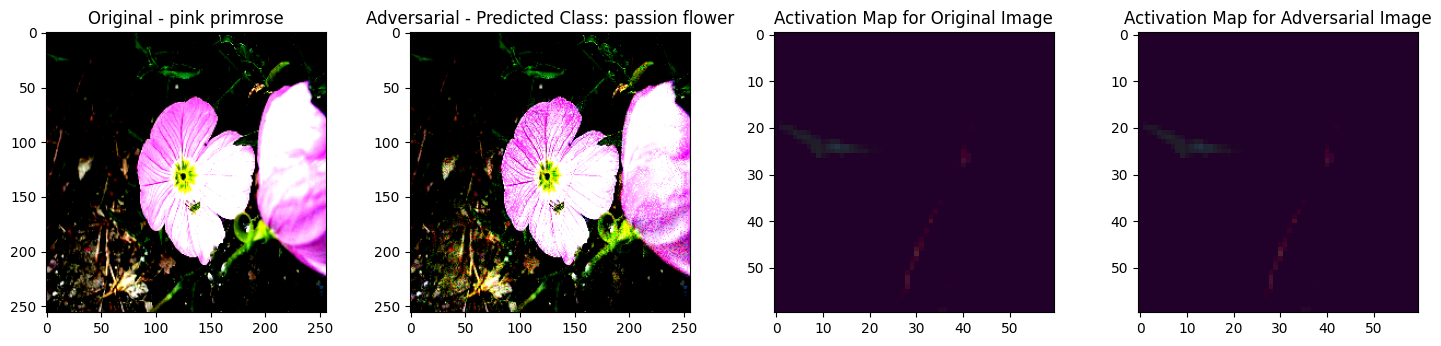

1/1 [==============================] - 0s 58ms/step


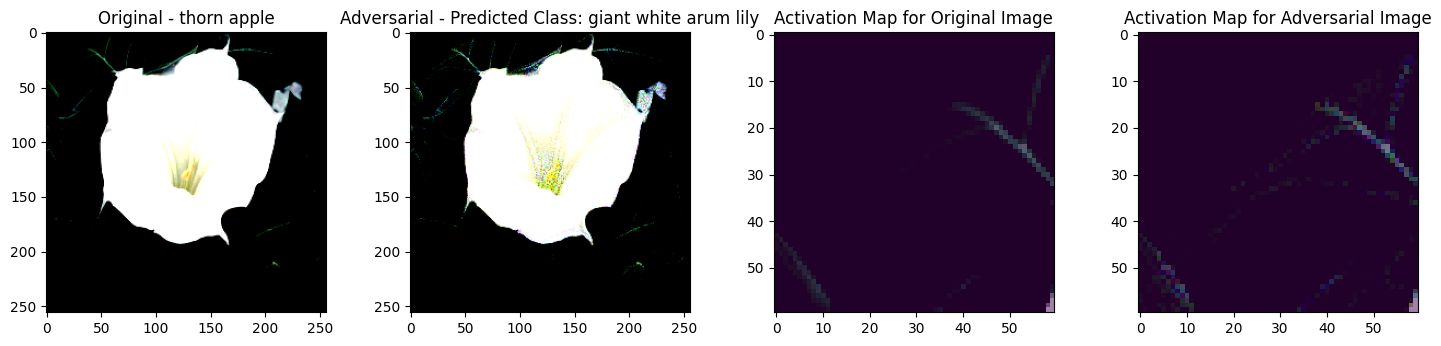

1/1 [==============================] - 0s 56ms/step


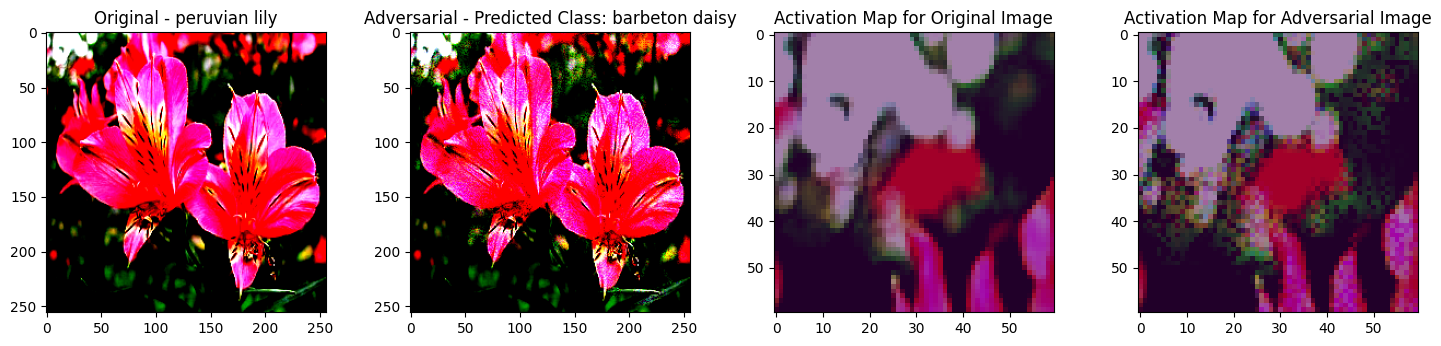

1/1 [==============================] - 0s 67ms/step


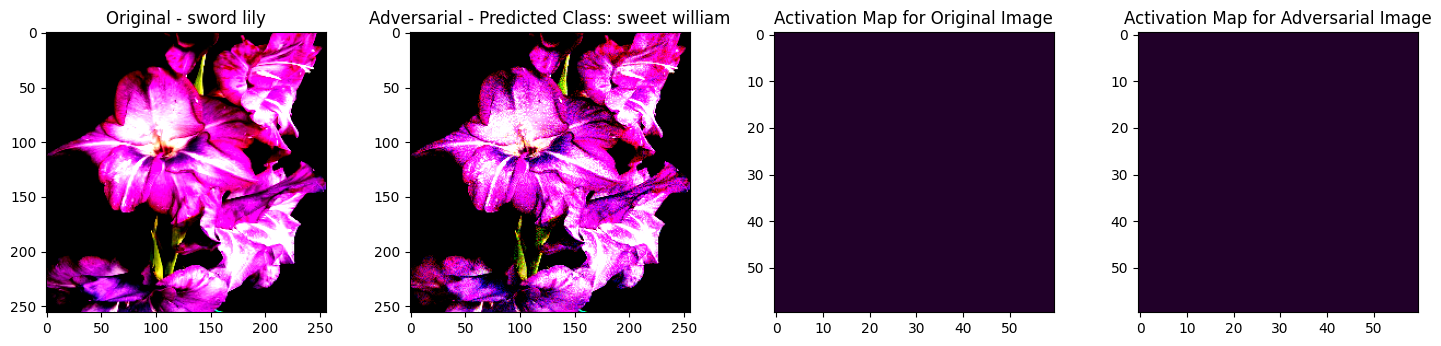

1/1 [==============================] - 0s 56ms/step


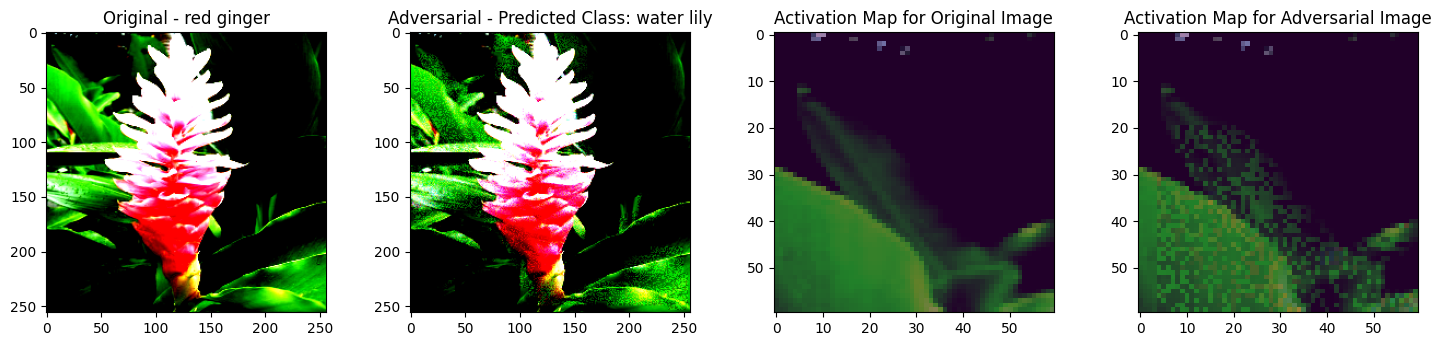

1/1 [==============================] - 0s 58ms/step


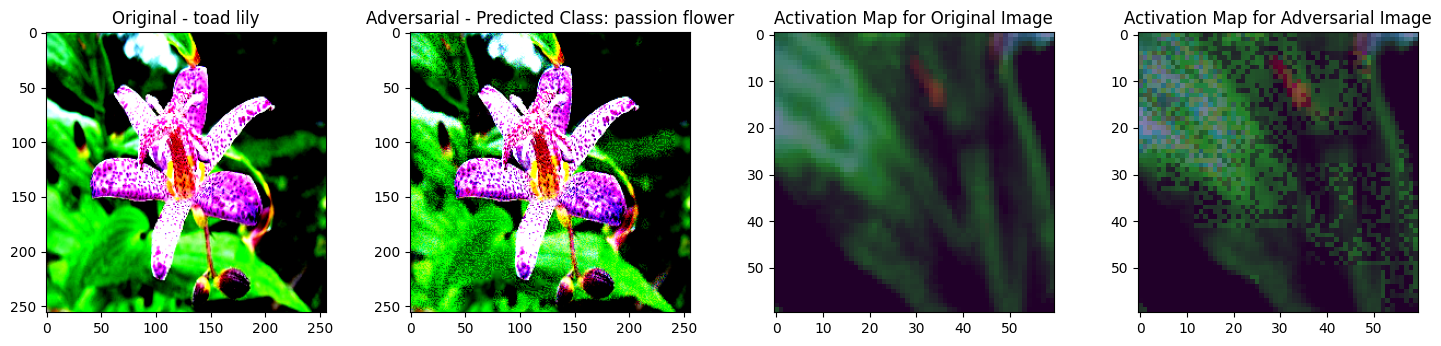

1/1 [==============================] - 0s 58ms/step


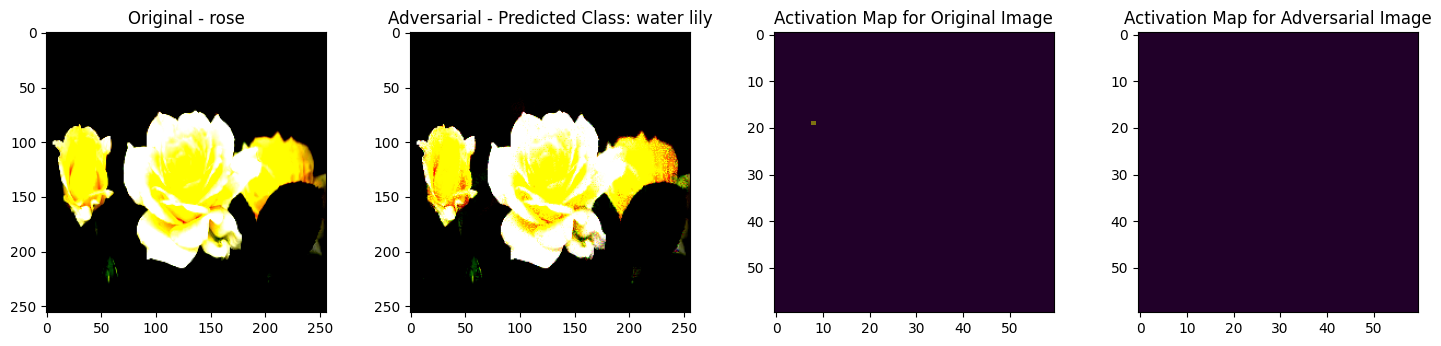

1/1 [==============================] - 0s 60ms/step


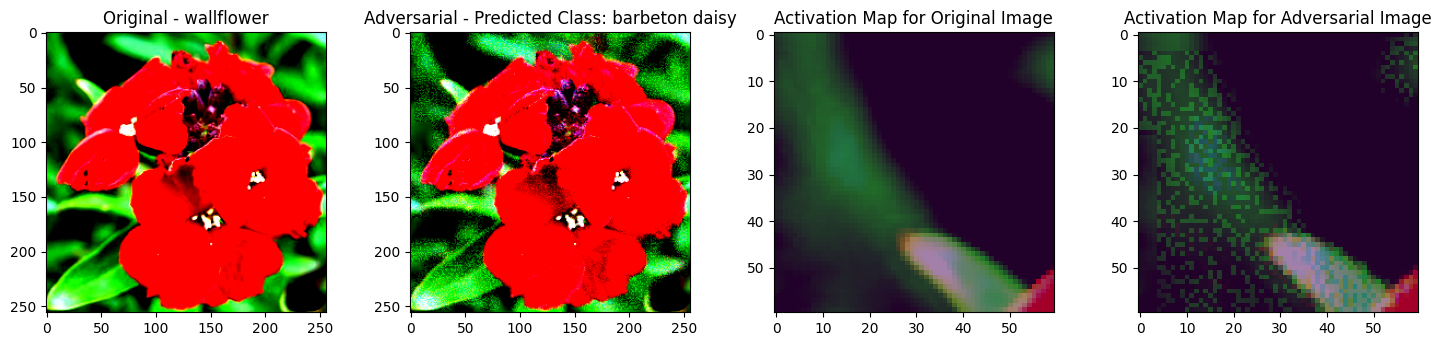

1/1 [==============================] - 0s 61ms/step


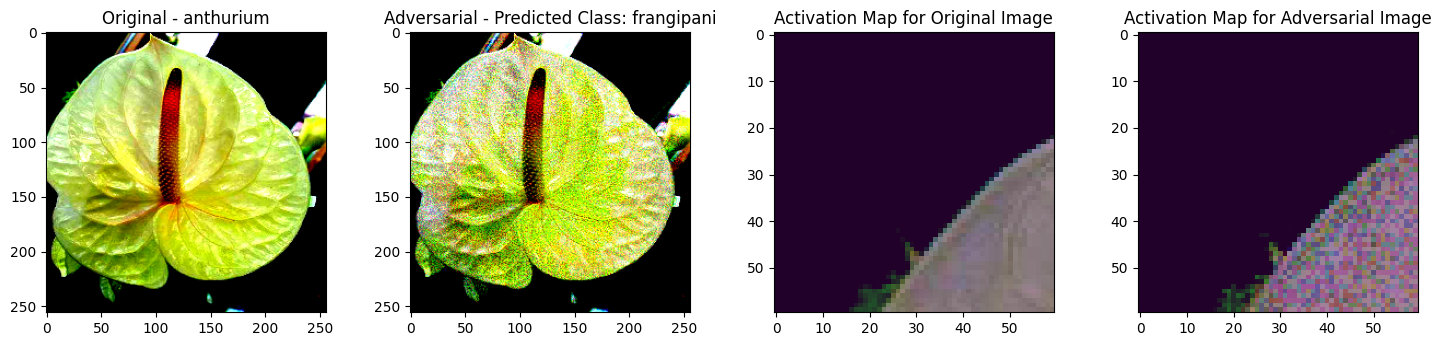

1/1 [==============================] - 0s 63ms/step


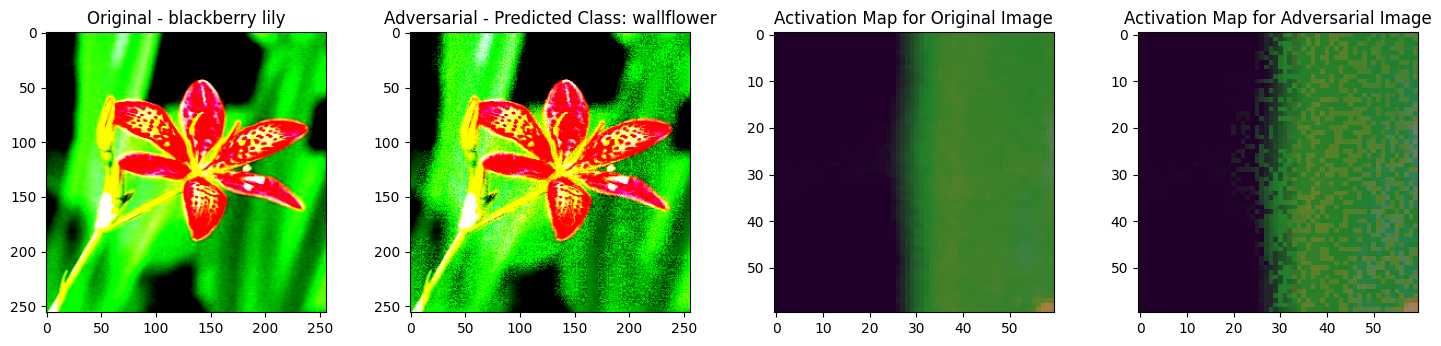

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
dataset, dataset_info = tfds.load('oxford_flowers102', split='test', with_info=True, as_supervised=True)
num_classes = dataset_info.features['label'].num_classes
class_names = dataset_info.features['label'].names
def preprocess_image(image, label):
    image = tf.image.resize(image, (256, 256))
    image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label, num_classes)
    return image, label
dataset = dataset.map(preprocess_image)
num_samples = dataset_info.splits['test'].num_examples
num_val_samples = int(0.1 * num_samples)
num_test_samples = num_samples - num_val_samples
val_dataset = dataset.take(num_val_samples)
test_dataset = dataset.skip(num_val_samples)
batch_size = 32
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
class_names = dataset_info.features['label'].names
model = Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(3, activation='tanh'))
    return model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model
train_images, train_labels = zip(*[(image.numpy(), label.numpy()) for image, label in dataset])
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
model.fit(train_dataset, epochs=1, validation_data=val_dataset)
art_classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(None, 224, 224, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
)
test_batch = next(iter(test_dataset))
test_images, test_labels = test_batch
test_images_np = test_images.numpy()
attack = FastGradientMethod(estimator=art_classifier, eps=0.2)
adversarial_test_images = attack.generate(test_images_np, y=test_labels.numpy())
def generate_activation_map(model, layer_index, input_image):
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[layer_index].output)
    activation = activation_model.predict(input_image[tf.newaxis, ...])
    return activation[0]
layer_index_to_visualize = 4
num_display = 25
for i in range(num_display):
    image_to_visualize_original = test_images[i]
    image_to_visualize_adversarial = adversarial_test_images[i]
    original_label_index = np.argmax(test_labels[i].numpy())
    original_label = class_names[original_label_index]
    activation_map_original = generate_activation_map(model, layer_index_to_visualize, image_to_visualize_original)
    activation_map_adversarial = generate_activation_map(model, layer_index_to_visualize, image_to_visualize_adversarial)
    plt.figure(figsize=(18, 8))
    plt.subplot(2, 4, 1)
    plt.imshow(image_to_visualize_original)
    plt.title(f'Original - {original_label}')
    plt.subplot(2, 4, 2)
    plt.imshow(image_to_visualize_adversarial)
    plt.title(f'Adversarial - Predicted Class: {class_names[np.argmax(art_classifier.predict(image_to_visualize_adversarial[tf.newaxis, ...]))]}')
    plt.subplot(2, 4, 3)
    plt.imshow(image_to_visualize_original)
    plt.imshow(activation_map_original[:, :, 0], cmap='viridis', alpha=0.5)
    plt.title(f'Activation Map for Original Image')
    plt.subplot(2, 4, 4)
    plt.imshow(image_to_visualize_adversarial)
    plt.imshow(activation_map_adversarial[:, :, 0], cmap='viridis', alpha=0.5)
    plt.title(f'Activation Map for Adversarial Image')
    plt.show()
